### Kaggle의 신용카드 데이터 세트를 이용한 신용카드 사기 검출 분류 실습
- [데이터 다운로드](http://www.kaggle.com/mlg-ulb/creditcardfraud)
- 해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다.
- 1은 신용카드 사기 트랜잭션을 의미하는데 전체 데이터의 0.172%만 레이블값이 1이다.
- 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적기 때문이다.

### <언더 샘플링과 오버 샘플링>
- 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출은 어려워진다.
- 지도학습에 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해선 오버샘플링, 언더샘플링 방법이 있고 오버샘플링 방식이 예측 성능상 더 유리한 경우가 많다.
- 언더 샘플링 
        많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소
- 오버 샘플링
        적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식
        동일한 데이터를 단순히 증식하는 방법은 과적합되기 때문에 의미가 없다. 그래서 원본 데이터의 피처 값들을 약간만 변경하여 
        증식한다.
        SMOTE(Synthetic Minority Over-sampling Techniique) 방법이 있다.
        적은 데이터 세트에 있는 개별 데이터들의 K최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 
        데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식
        SMOTE를 구현한 파이썬 패키지는 imbalanced-learn이다.
        이를 이용하여 데이터 증식을 해본다.
        

### 데이터 1차 가공 및 모델 학습/예측/평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

card_df=pd.read_csv('./data/creditcard.csv')
card_df.head()

In [2]:
card_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

- V로 시작하는 피처들의 의미는 알 수가 없다.
- Time 피처의 경우 큰 의미가 없기에 제거.
- Amount 피처는 신용카드 트랙잭션 금액
- Class는 레이블로 0의경우 정상 1의 경우 사기




### 데이터 전처리
- 입력된 DataFrame을 복사한 뒤 이를 가고앟여 반환하는 get_preprocessed_df() 함수.
- 데이터 가공 후 학습/테스트 데이터 세트를 반환하는 get_train_test_df() 함수.


In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사하고 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy


In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    #학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


- 학습/테스트 데이터들의 레이블 1의 값이 1.72, 1.73으로 큰 차이 없이 잘 분할 됐다.
- 모델을 생성한다. 로지스틱 회귀, LGBM 기반 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴본다.

In [6]:
def get_clf_eval(y_test, pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score,roc_auc_score

    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print("정확도 : {:.4f}, 정밀도 : {:.4f}, 재현율 : {:.4f}, F1 :{:.4f}, ROC-AUC : {:.4f}".format(accuracy, precision, recall,f1, roc_auc))
  

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
get_clf_eval(y_test, lr_pred)

오차 행렬
[[85282    13]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8738, 재현율 : 0.6081, F1 :0.7171, ROC-AUC : 0.8040


- 별도의 테스트 데이터 세트로 측정 할 때 재현율이 약 60.81%, ROC-AUC가 80.4%이다.
- 이번에는 LGBM 모델을 만들어본다.
- 반복적으로 모델을 변경해 학습/예측/평가 할 것이므로 이를 위한 별도의 함수를 생성한다.

In [8]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아 학습/예측/평가를 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)
    

In [9]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train= X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9492, 재현율 : 0.7568, F1 :0.8421, ROC-AUC : 0.8783


- 재현율 75.68%, ROC-AUC 87.83%로 로지스틱 회귀보단 높은 점수.


### 데이터 분포도 변환 후 모델 학습/예측/평가
- 왜곡된 분포도를 가지는 데이터를 재가공한 뒤 모델을 다시 테스트
- 로지스틱회귀는 선형모델로 선형모델은 중요피처들의 값이 정규분포 형태를 유지하는것을 선호한다.
- Amount 피처는 이 데이터에서 중요한 속성일 가능성이 높으므로 Amount 피처의 분포도를 보도록한다.

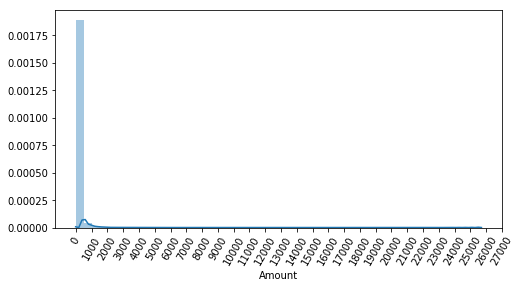

In [10]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])
plt.show()

- 사용금액이 1000불 이하인 데이터가 대부분이고 27000불 까지 종종 데이터가 있다.
- 앞의 get_preprocessed_df() 함수를 수정한다.

In [11]:
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

- 함수를 수정 후 로지스틱회귀, LGBM 모델을 각각 학습/예측/평가 해본다.

In [12]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081, F1 :0.7143, ROC-AUC : 0.8040
### LGBM 예측 성능
오차 행렬
[[85289     6]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9492, 재현율 : 0.7568, F1 :0.8421, ROC-AUC : 0.8783


- 변화가 없다.
- 이번에는 StandardScaler가 아니라 로그 변환을 수행해 본다.
- get_preprocessed_df()를 수정 후 확인해본다.

In [13]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8824, 재현율 : 0.6081, F1 :0.7200, ROC-AUC : 0.8040
### LGBM 예측 성능
오차 행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576, 재현율 : 0.7635, F1 :0.8496, ROC-AUC : 0.8817


- 두 모델 약간씩 성능 개선이 됐지만 미비한 수준.


### < 이상치 데이터 제거 후 모델 학습/예측/평가 >

- 이상치를 찾는 방법은 여러가지가 있지만 IQR(Inter Quantile Range) 방식을 적용해본다.
- IQR은 사분위 값의 편차를 이용하는 기법. 박스플롯으로 시각화할 수 있다.
- 25% 구간인 Q1, ~75% 구간잉ㄴ Q3의 범위를 IQR 이라고 한다.
- IQR을 이용해 이상치 데이터를 검 출하는 방식은 보통 IQR에 1.5를 곱해 생성된 범위를 이용해서 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치 데이터로 판단한다.
- 경우에 따라 1.5가 아닌 다름 값을 적용할 수도 있지만 보통은 1.5를 적용한다.

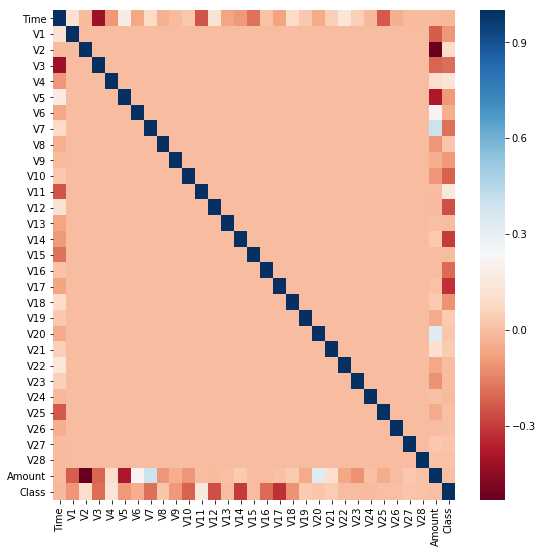

In [15]:
import seaborn as sns
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')
plt.show()

- 히트맵에서 cmap을 'RdBu'로 설정하면 양의 상관관계에 가까울수록 색깔이 진한 파란색이 가깝고 음의 상관관계에 가까울수록 진한 빨간색에 가깝게 표현된다.
- Class 피처와 음의 상관관계가 가장 높은 피처는 V14 와 V17로 이 중 V14에 대해서 이상치를 찾아서 제거해보도록한다.

In [16]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출,1/4, 3/4 분위 지점을 np.percentile로 구한다.
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR을 구하고 IQR에 1.5를 곱해 최댓값, 최솟값 지점을 구한다.
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val= quantile_25-iqr_weight
    highest_val = quantile_75+iqr_weight
    
    # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설저앟고 DataFrame index 반환
    outlier_index = fraud[(fraud<lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [17]:
outlier_index = get_outlier(df = card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스 ', outlier_index)

이상치 데이터 인덱스  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


- 총 4개의 데이터가 추출됐다.  
- get_outlier()를 get_preprocessed_df 함수에 추가해 가공한 뒤 LGBM 모델에 적용해본다

In [18]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [19]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8829, 재현율 : 0.6712, F1 :0.7626, ROC-AUC : 0.8355
### LGBM 예측 성능
오차 행렬
[[85291     4]
 [   25   121]]
정확도 : 0.9997, 정밀도 : 0.9680, 재현율 : 0.8288, F1 :0.8930, ROC-AUC : 0.9144


- 두 모델 모두 예측성능이 크게 향상됐다.
- 로지스틱 회귀는 60.81% -> 67.12%
- LGBM 은 76.35% -> 82.88%

### < SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가 >
- imbalanced-learn 패키지의 SMOTE클래스를 이용하여 구현

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 1    199020
0    199020
dtype: int64


- 이렇게 생성된 학습 데이터 세트를 기반으로 로지스틱 회귀 모델을 학습한 뒤 성능 평가를 해본다.

In [21]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82932  2363]
 [   11   135]]
정확도 : 0.9722, 정밀도 : 0.0540, 재현율 : 0.9247, F1 :0.1021, ROC-AUC : 0.9485


- 재현율이 92.47%로 크게 증가 했지만 반대로 정밀도가 5.4%로 급격하게 떨어졌다.
- 재현율이 높더라도 저조한 정밀도면 현실 업무에 적용할 수 없다.
- 이는 로지스틱 회귀 모델이 오버 샘플리으로 인해 실제 원본 데이터의 유형보다 많은 Class=1 데이터를 학습하여 실제 테스트 데이터 세트에서도 Class=1로 많이 예측하여 정밀도가 급격히 떨어졌다.
- 분류결정 임곗값에 따른 정밀도,재현율 곡선을 통해서 SMOTE로 학습된 로지스틱 회귀 모델을 살펴본다.


In [24]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X 축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 축의 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x 축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

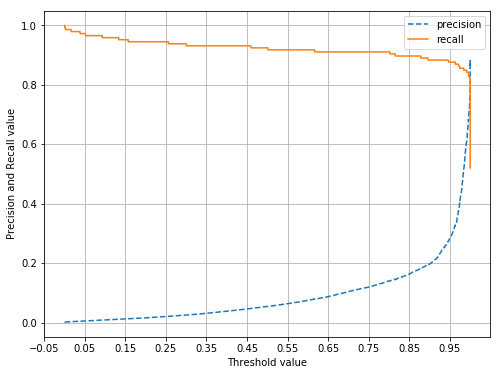

In [25]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- 임곗값이 0.99 이하에서 재현율이 매우좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다.
- 분류결정 임곗값을 조정해도 민감도가 너무 심해 좋은 성능을 기대하기가 어렵다.
- 이번에는 LGBM 모델로 학습/예측/평가 한다.

In [26]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9323, 재현율 : 0.8493, F1 :0.8889, ROC-AUC : 0.9246


- 재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 되었지만 정밀도는 더 낮아졌다.
- SMOTE를 적용하면 대부분 재현율은 높아지지만 정밀도는 낮아지는 것이 일반적이다.